###  Simulateing Train Station Scene

This file simulated the process of taking the train in the train station in real life, and calculated the average waiting time of passengers and trains under different conditions.

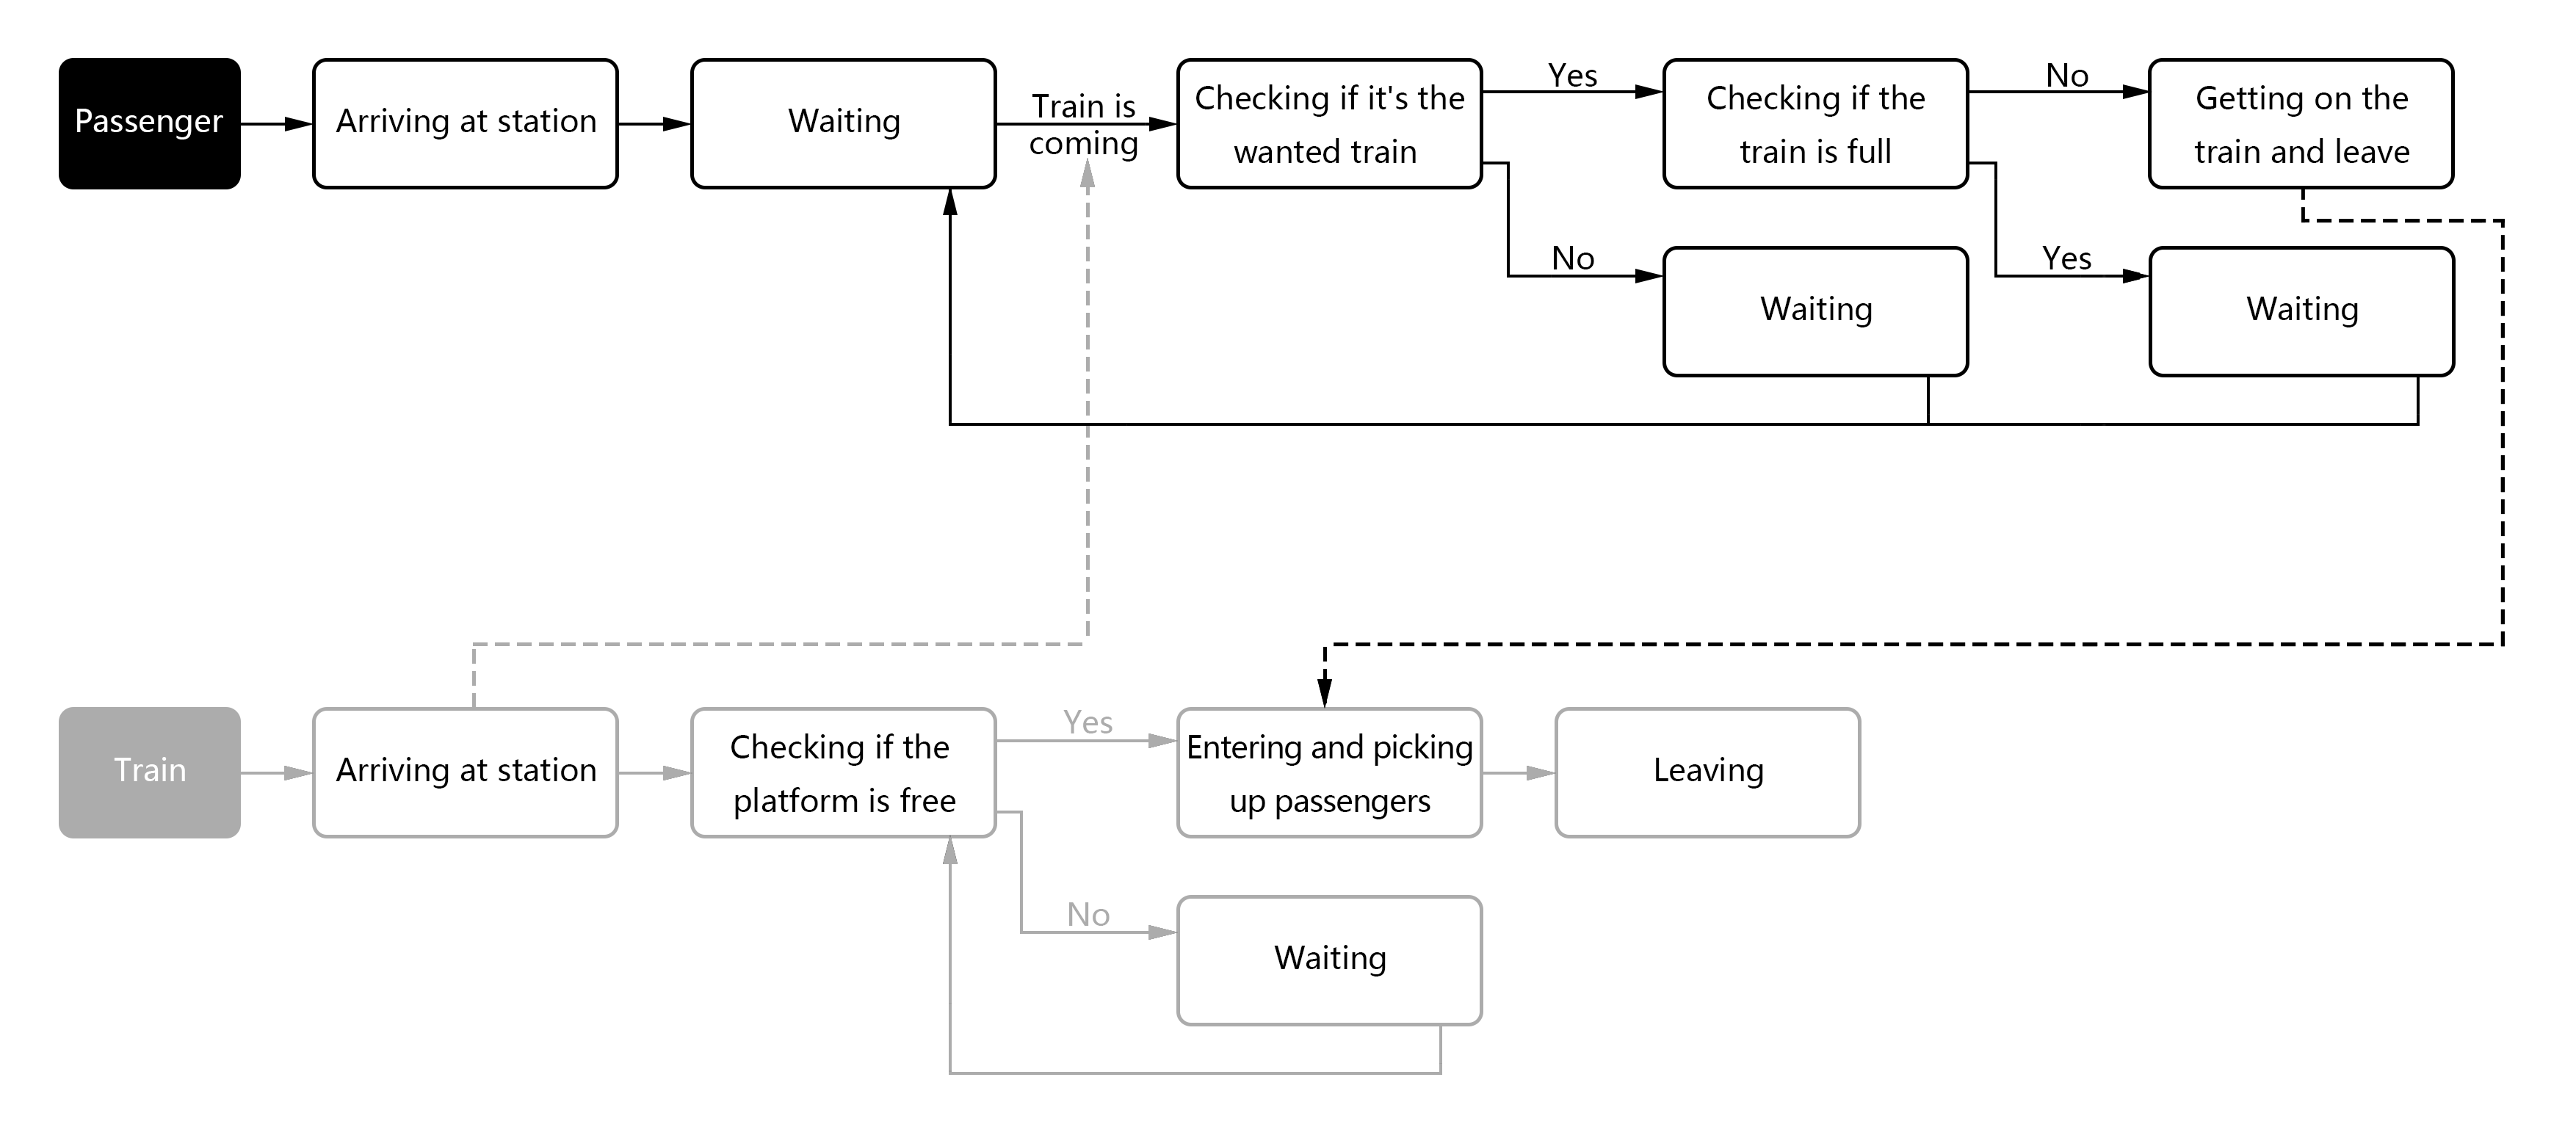


* **The station:** we assume that this station has 2 platforms, and there are 5 train lines pass through this station.  


* **Passenger behaviors:**
  * Passengers will first arrive at the platform after buying tickets and wait for the train to arrive.
  * After the train arrives, they will check whether the train is what they want to take.
  * If the train is what they want to take and the train is not full, they get on.
  * Otherwise, they continue to wait until the next train that they want and is not full arrives.   
  
  
* **Train behaviors:**
  * We assume that trains arrive at the station every 2 minutes.
  * The maximum capacity of a train is 100 people (we don't want to use large numbers for simulation). There will be a random initial capacity when a train arrives at the station.
  * As the station has only 2 platforms, the train arrives and first checks to see if the platform is empty.
  * If the platform is free, the train enters the station and carries passengers, we assume it will stay for 5 minutes and then leave.
  * If the platform is not free, the train needs to wait for the last train to leave before entering the platform, and then carry passengers and leave.

------------------------------------
<br/>

In [1]:
import simpy
import random
import statistics

In [2]:
# Parameters

# Parameters for controlling trains' and passengers' arriving time
std_walking = 0.5
std_driving = 1

# The interval between the two trains
interval = 2

# How long does the train stay at the station
stay_duration = 5

# The numbers of trains and passengers
num_train = 5
num_passenger = 100

# The capacity of trains
train_capacity = 100
mean_initial_capacity = 70
std_initial_capacity = 5

# Number of people getting off
mean_get_off = 5
std_get_off = 2

# Lists for calculating capacity of each train
num_get_on = []
current_capacity = []
leaving_capacity = []
for i in range(num_train):
    num_get_on.append(0)
    current_capacity.append(0)
    leaving_capacity.append(0)

# Lists for checking which trains are at the station
trains_in_station = []
train_list = []
for i in range(num_train):
    train_list.append(i)

# Lists for calculating the average waiting time
train_waiting_time = []
passenger_waiting_time = []

In [3]:
# The function which determines whether it is the train the passengers want
def want_or_not(a,b):
    new_list = list(set(a) & set(b))
    if new_list:
        return True
    else:
        return False

In [4]:
# The function which defines a train arrival, queuing, picking up and departure behaviour
def train(env, name, platform, mean_driving, ID):
    global trains_in_station
    global num_get_on
    global leaving_capacity
    global current_capacity
    
    while True:
        # Simulate the capacity when the train arriving
        arriving_capacity = random.gauss(mean_initial_capacity, std_initial_capacity)
        num_get_off = random.gauss(mean_get_off,std_get_off) 
        current_capacity[ID] = arriving_capacity - num_get_off

        # Arrive at station
        driving_time = random.gauss(mean_driving, std_driving)
        yield env.timeout(driving_time)
        print('----------------------------------------------------')
        print('%s arriving at %.1f, with an available capacity of (%d)' % (name, env.now, current_capacity[ID]))
        train_arriving_time=env.now

        # Request one of a platform
        with platform.request() as req:
            yield req
            # Pick up passengers
            trains_in_station.append(ID)
            print('----------------------------------------------------')
            print('%s starting to pick up passengers at %.1f' % (name, env.now))
            print('----------------------------------------------------')
            print('Now the trains at the station are Train %s' % (trains_in_station))
            print('----------------------------------------------------')
            train_picking_up_time = env.now
            
            # Leave the station
            yield env.timeout(stay_duration)
            trains_in_station.remove(ID)
            print('----------------------------------------------------')
            print('%s leaving the station at %.1f, with a capacity of (%d)' % (name, env.now, leaving_capacity[ID]))
            print('----------------------------------------------------')
            print('Now the trains at the station are Train %s' % (trains_in_station))
            print('----------------------------------------------------')
            
            # Reset counters
            num_get_on[ID] = 0
            leaving_capacity[ID] = 0
            current_capacity[ID] = 0

            # Calculate the waiting time of the train
            train_waiting_time.append(train_picking_up_time-train_arriving_time)

In [5]:
# The function which defines a passenger arrival, waiting, checking and getting on behaviour
def passenger(env, name, mean_walking):
    global trains_in_station
    global num_get_on
    global leaving_capacity
    global current_capacity

    # Simulate wanted train
    num_wanted_train = []
    for i in range(num_train):
        num_wanted_train.append(i+1)
    num = random.choice(num_wanted_train) 
    wanted_train = random.sample(train_list, num)

    # Arrive at station
    walking_time = random.gauss(mean_walking, std_walking)
    yield env.timeout(walking_time)
    print('%s arriving at %.1f, wanting Train %s' % (name, env.now, wanted_train))
    passenger_arriving_time=env.now

    # Wait for trains
    while True:
        yield env.timeout(0.1)
        new_list = list(set(wanted_train) & set(trains_in_station))
        
        # Check if it's the wanted train
        if want_or_not(trains_in_station, wanted_train):
            # Check if the train is full
            for i in new_list:
                if leaving_capacity[i] <= train_capacity:
                    # Calculate Capacity
                    num_get_on[i] += 1
                    leaving_capacity[i] = current_capacity[i] + num_get_on[i]

                    # Get on
                    print('%s getting on Train [%s] at %.1f, current capacity (%d)' % (name, i, env.now, leaving_capacity[i]))
                    passenger_leaving_time = env.now
                    
                    # Calculate the waiting time of passengers
                    passenger_waiting_time.append(passenger_leaving_time-passenger_arriving_time)
                    break
            break

In [6]:
# The function which calculate the average waiting time
def average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [7]:
env = simpy.Environment()
platform = simpy.Resource(env, capacity = 2)

In [8]:
for i in range(num_train):
    env.process(train(env, 'Train %d' % i, platform, i*interval+10, i))

for j in range(2):    # Simulate that some people may arrive at the station at the same time
    for i in range(num_passenger):
        s = str(j) + '_' + str(i)
        env.process(passenger(env, 'Passenger %s' % s, i*0.2+8))

In [9]:
env.run(30)
print('****************************************************')
train_mins, train_secs = average_wait_time(train_waiting_time)
print('The average waiting time of the train is %s minutes and %s seconds' % (train_mins, train_secs))
passenger_mins, passenger_secs = average_wait_time(passenger_waiting_time)
print('The average waiting time of the passenger is %s minutes and %s seconds' % (passenger_mins, passenger_secs))

Passenger 1_0 arriving at 8.0, wanting Train [0, 4, 1, 3]
Passenger 0_1 arriving at 8.0, wanting Train [3, 1, 4, 2, 0]
Passenger 0_6 arriving at 8.1, wanting Train [1, 4, 3, 2]
Passenger 0_0 arriving at 8.1, wanting Train [0, 2, 4]
Passenger 0_2 arriving at 8.2, wanting Train [1]
Passenger 0_3 arriving at 8.3, wanting Train [1]
Passenger 1_3 arriving at 8.4, wanting Train [4, 3, 0, 2, 1]
Passenger 1_5 arriving at 8.5, wanting Train [3, 0, 1, 2, 4]
Passenger 1_1 arriving at 8.8, wanting Train [4, 0]
Passenger 1_4 arriving at 8.9, wanting Train [4, 0, 1, 2]
Passenger 1_7 arriving at 9.0, wanting Train [1, 4, 0, 2, 3]
Passenger 1_2 arriving at 9.2, wanting Train [1, 4, 3]
Passenger 0_5 arriving at 9.6, wanting Train [4, 1, 0]
Passenger 1_8 arriving at 9.6, wanting Train [0, 3, 1, 4, 2]
----------------------------------------------------
Train 0 arriving at 9.7, with an available capacity of (58)
----------------------------------------------------
Train 0 starting to pick up passengers a